<a href="https://colab.research.google.com/github/chees-ea/Neural-Networks-house-number-and-digit-recognition/blob/main/CNN_Project_Chelsea_Lord.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project - Convolutional Neural Networks: Street View Housing Number Digit Recognition**

# Marks: 30

Welcome to the project on classification using Convolutional Neural Networks. We will continue to work with the Street View Housing Numbers (SVHN) image dataset for this project.

--------------
### **Context:** 
--------------

One of the most interesting tasks in deep learning is to recognize objects in natural scenes. The ability to process visual information using machine learning algorithms can be very useful as demonstrated in various applications.

The SVHN dataset contains over 600,000 labeled digits cropped from street-level photos. It is one of the most popular image recognition datasets. It has been used in neural networks created by Google to improve map quality by automatically transcribing the address numbers from a patch of pixels. The transcribed number with a known street address helps pinpoint the location of the building it represents. 

----------------
### **Objective:**
----------------

Build a CNN model that can identify the digits in the images.

-------------
### **Dataset**
-------------
Here, we will use a subset of the original data to save some computation time. The dataset is provided as a .h5 file. The basic preprocessing steps have been done.

## **Mount the drive**
Let us start by mounting the drive and importing the necessary libraries.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Importing libraries**

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, LeakyReLU
from tensorflow.keras.utils import to_categorical

Let us check for the version of TensorFlow.

In [4]:
print(tf.__version__)

2.8.0


## **Load the dataset**
- Let us now load the dataset that is available as a .h5 file.
- Split the data into train and the test dataset

In [5]:
import h5py

# Open the file as read only
# User can make changes in the path as required
h5f = h5py.File('/content/drive/MyDrive/SVHN_single_grey1.h5', 'r')

# Load the training and the test set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]


# Close this file
h5f.close()

Let's check the number of images in the training and testing data.

In [6]:
len(X_train), len(X_test)

(42000, 18000)

**Observations**
- There are 42,000 images in the training data and 18,000 images in the testing data. 

## **Visualizing images**
- Use X_train to visualize the first 10 images
- Use Y_train to print the first 10 labels

#### **Question 1: Complete the below code to visualize the first 10 images from the training data (1 Mark)**

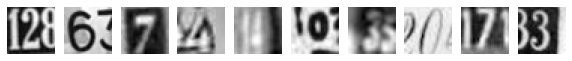

label for each of the above image: [2 6 7 4 4 0 3 0 7 3]


In [7]:
# visualizing the first 10 images in the dataset and their labels
plt.figure(figsize=(10, 1))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i], cmap="gray") # write the function to visualize images
    plt.axis('off')

plt.show()
print('label for each of the above image: %s' % (y_train[0:10]))

## **Data Preparation**

- Print the first image in the train image and figure out the shape of the images
- Reshape the train and the test dataset to make them fit the first convolutional operation that we will create later. Figure out the required shape
- Normalize the train and the test dataset by dividing by 255
- Print the new shapes of the train and the test set
- One-hot encode the target variable

In [8]:
# Shape of the images and the first image

print("Shape:", X_train[0].shape)
print()
print("First image:\n", X_train[0])

Shape: (32, 32)

First image:
 [[ 33.0704  30.2601  26.852  ...  71.4471  58.2204  42.9939]
 [ 25.2283  25.5533  29.9765 ... 113.0209 103.3639  84.2949]
 [ 26.2775  22.6137  40.4763 ... 113.3028 121.775  115.4228]
 ...
 [ 28.5502  36.212   45.0801 ...  24.1359  25.0927  26.0603]
 [ 38.4352  26.4733  23.2717 ...  28.1094  29.4683  30.0661]
 [ 50.2984  26.0773  24.0389 ...  49.6682  50.853   53.0377]]


In [9]:
# Reshaping the dataset to flatten them. Remember that we always have to give a 4D array as input to CNNs

X_train = X_train.reshape(X_train.shape[0], 32,32,1)
X_test = X_test.reshape(X_test.shape[0], 32,32,1)

In [10]:
# Normalize inputs from 0-255 to 0-1

X_train = X_train / 255.0
X_test = X_test / 255.0

In [11]:
# New shape 

print('Training set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Training set: (42000, 32, 32, 1) (42000,)
Test set: (18000, 32, 32, 1) (18000,)


#### **Question 2: One-hot encode the labels in the target variable y_train and y_test (2 Marks)**

In [12]:
#Write the function and appropriate variable name to one-hot encode the output

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

#test labels
y_test

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

- Notice that each entry of y_test is a one-hot encoded vector instead of a single label.

## **Model Building**

Now, we have done data preprocessing, let's build a CNN model.

In [13]:
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

### **Model Architecture**
- Write a function that returns a sequential model with the following architecture
 - First Convolutional layer with **16 filters and kernel size of 3x3**. Use the **'same' padding** and provide an **apt input shape**
 - Add a **LeakyRelu layer** with the **slope equal to 0.1**
 - Second Convolutional layer with **32 filters and kernel size of 3x3 with 'same' padding**
 - Another **LeakyRelu** with the **slope equal to 0.1**
 - A **max-pooling layer** with a **pool size of 2x2**
 - **Flatten** the output from the previous layer
 - Add a **dense layer with 32 nodes**
 - Add a **LeakyRelu layer with slope equal to 0.1**
 - Add the final **output layer with nodes equal to the number of classes** and **softmax activation**
 - Compile the model with the **categorical_crossentropy loss, adam optimizers (learning_rate = 0.001), and accuracy metric**. Do not fit the model here, just return the compiled model
- Call the function and store the model in a new variable
- Print the summary of the model.
- Fit the model on the train data with a **validation split of 0.2, batch size = 32, verbose = 1, and 20 epochs**. Store the model building history to use later for visualization.

#### **Question 3: Build and train a CNN model as per the above mentioned architecture (10 Marks)**

In [73]:
np.shape(X_test)

(18000, 32, 32, 1)

In [72]:
#reshaping the data to fit the CNN model
x_train = X_train.reshape(42000,32,32,1)
x_test = X_test.reshape(18000,32,32,1)

In [74]:
#Importing losses and optimizers modules
from tensorflow.keras import losses
from tensorflow.keras import optimizers

#Define the function
def cnn_model_1():
    model = Sequential() 
    #Add layers as per the architecture mentioned above in the same sequence
    #first layer with 16 filters, kernel size 3x3, same padding
    model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', input_shape=(32, 32, 1)))
    #Leakyrelu leayer, 0.1 slope
    model.add(LeakyReLU(0.1))
    #2nd layer, 32 filters, 3x3 kernel size, same padding
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=(32, 32, 1)))
    #another Leakyrelu layer
    model.add(LeakyReLU(0.1))
    #max-poolinglayer with a pool size 2x2
    model.add(MaxPool2D(pool_size=(2,2)))
    #flatten output
    model.add(Flatten())
    #dense layer with 32 nodes
    model.add(Dense(32))
    model.add(LeakyReLU(0.1))
    #final output layer
    model.add(Dense(10, activation='softmax'))

    #declare adam optimizer with learning rate of 0.001 
    adam = optimizers.Adam(learning_rate=0.01)
    
    #compile the model
    model.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])
    return model

In [75]:
#Build the model
model_1 = cnn_model_1()

#adding first conv layer with 16 filters, Kernel size 3x3
model_1

In [76]:
#Print the model summary
model_1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 16)        160       
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 32, 32, 16)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 8192)              0         
                                                      

The model structure has:

- 2 convolution layers with 16 filters each of size (3,3) and 'same' padding i.e. the output would be of same size as the input except the depth which would be equal to 16.
- Max pooling of size (2,2) is applied on the output of the second layer.
- The output of max pooled images is flattened using the Flatten layer.
- A Leaky ReLU layer with a slope of 0.1 in between the convolutional layers is used for best train accuracy & validation accuracy. 
- A Dense layer is used to create a fully connected layer with 64 nodes has been applied to the output of the Flatten layer
- Finally, the softmax layer with 10 nodes to get the probabilities of each observation belonging to each class.

**Key Notes:** Each node in the batch normalization layer has two non-trainable parameters - mean and variance. Here, we have 2 batch normalization layers with 64 and 16 nodes. So, the model has (64+16)*2 = 160 non-trainable parameters.

In [77]:
np.shape(X_train)

(42000, 32, 32, 1)

In [78]:
# Fit the model
history_model_1 = model_1.fit(X_train, y_train, validation_data=(X_test, y_test), validation_split=0.2, verbose = 1, batch_size=32, epochs = 20)

Epoch 1/20
1313/1313 [==============================] - 26s 11ms/step - loss: 2.3326 - accuracy: 0.1020 - val_loss: 2.3331 - val_accuracy: 0.1213
Epoch 2/20
1313/1313 [==============================] - 15s 11ms/step - loss: 3.7688 - accuracy: 0.1179 - val_loss: 2.2404 - val_accuracy: 0.2259
Epoch 3/20
1313/1313 [==============================] - 15s 11ms/step - loss: 1.9957 - accuracy: 0.2945 - val_loss: 1.6992 - val_accuracy: 0.4197
Epoch 4/20
1313/1313 [==============================] - 18s 14ms/step - loss: 1.4178 - accuracy: 0.5422 - val_loss: 1.1539 - val_accuracy: 0.6497
Epoch 5/20
1313/1313 [==============================] - 15s 12ms/step - loss: 0.9980 - accuracy: 0.6942 - val_loss: 0.9015 - val_accuracy: 0.7373
Epoch 6/20
1313/1313 [==============================] - 16s 12ms/step - loss: 0.7461 - accuracy: 0.7787 - val_loss: 0.6878 - val_accuracy: 0.8036
Epoch 7/20
1313/1313 [==============================] - 17s 13ms/step - loss: 0.7445 - accuracy: 0.7842 - val_loss: 0.7048 -

### **Plotting the validation and training accuracies**

#### **Question 4: Write your observations on the below plot (2 Marks)**

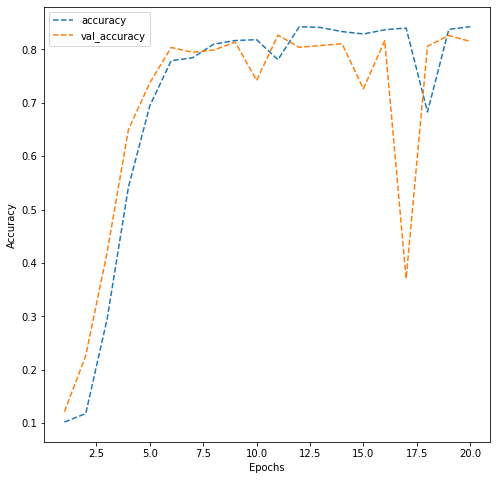

In [79]:
# plotting the accuracies

dict_hist = history_model_1.history
list_ep = [i for i in range(1,21)]

plt.figure(figsize = (8,8))
plt.plot(list_ep,dict_hist['accuracy'],ls = '--', label = 'accuracy')
plt.plot(list_ep,dict_hist['val_accuracy'],ls = '--', label = 'val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

**Observations:**
- The more epochs(hyperparameters) established in the model the better the accuracy of the model. 
-However, there was a weird blip at around 17.5 for the validation data that then caused the overall accuracy to also take a dip, but then shot back up. Could be potentially overfitting the dataset, it could be useful to cut down on the number of Epochs (to 15) to see how it runs after that. 

Let's build another model and see if we can get a better model with generalized performance.

First, we need to clear the previous model's history from the keras backend. Also, let's fix the seed again after clearing the backend.

In [80]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [81]:
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

### **Second Model Architecture**
- Write a function that returns a sequential model with the following architecture
 - First Convolutional layer with **16 filters and kernel size of 3x3**. Use the **'same' padding** and provide an **apt input shape**
 - Add a **LeakyRelu layer** with the **slope equal to 0.1**
 - Second Convolutional layer with **32 filters and kernel size of 3x3 with 'same' padding**
 - Add **LeakyRelu** with the **slope equal to 0.1**
 - Add a **max-pooling layer** with a **pool size of 2x2**
 - Add a **BatchNormalization layer**
 - Third Convolutional layer with **32 filters and kernel size of 3x3 with 'same' padding**
 - Add a **LeakyRelu layer with slope equal to 0.1**
 - Fourth Convolutional layer **64 filters and kernel size of 3x3 with 'same' padding** 
 - Add a **LeakyRelu layer with slope equal to 0.1**
 - Add a **max-pooling layer** with a **pool size of 2x2**
 - Add a **BatchNormalization layer**
 - **Flatten** the output from the previous layer
 - Add a **dense layer with 32 nodes**
 - Add a **LeakyRelu layer with slope equal to 0.1**
 - Add a **dropout layer with rate equal to 0.5**
 - Add the final **output layer with nodes equal to the number of classes** and **softmax activation**
 - Compile the model with the **categorical_crossentropy loss, adam optimizers (learning_rate = 0.001), and accuracy metric**. Do not fit the model here, just return the compiled model
- Call the function and store the model in a new variable
- Print the summary of the model.
- Fit the model on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and 30 epochs**. Store the model building history to use later for visualization.

#### **Question 5: Build and train the second CNN model as per the above mentioned architecture (10 Marks)**

In [100]:
#Define the function
def cnn_model_2():
    #input_shape=X_train.shape[1:]
    model = Sequential() 
    #Add layers as per the architecture mentioned above in the same sequence
    #FIRST layer with 16 filters, kernel size 3x3, same padding
    model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', input_shape=(32, 32, 1)))
    #Leakyrelu leayer, 0.1 slope
    model.add(LeakyReLU(0.1))
    #2ND layer, 32 filters, 3x3 kernel size, same padding
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=(32, 32, 1)))
    #another Leakyrelu layer
    model.add(LeakyReLU(0.1))
    #max-poolinglayer with a pool size 2x2
    model.add(MaxPool2D(pool_size=(2,2)))
    #batch normalization
    model.add(BatchNormalization())
    #THIRD layer
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=(32, 32, 1)))
    #another Leakyrelu layer
    model.add(LeakyReLU(0.1))
    #FOURTH layer
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', input_shape=(64, 64, 1)))
    #another Leakyrelu layer
    model.add(LeakyReLU(0.1))
    #max-poolinglayer with a pool size 2x2
    model.add(MaxPool2D(pool_size=(2,2)))
    #batch normalization
    model.add(BatchNormalization())
    #flatten output
    model.add(Flatten())
    #dense layer with 32 nodes
    model.add(Dense(32))
    #Leaky ReLU
    model.add(LeakyReLU(0.1))
    #droput
    model.add(Dropout(0.5))
    #final output layer
    model.add(Dense(10, activation='softmax'))

    #declare adam optimizer with learning rate of 0.001 
    adam = optimizers.Adam(learning_rate=0.01)
    
    #compile the model
    model.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])
    return model

In [101]:
# Build the model
model_2 = cnn_model_2()

In [102]:
#Print the summary
model_2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 16)        160       
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 32, 32, 16)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                      

In [103]:
# Fit the model
history_model_2 = model_2.fit(X_train, y_train, validation_data=(X_test, y_test),validation_split=0.2, verbose = 1, batch_size=128, epochs = 30)

Epoch 1/30
263/263 [==============================] - 11s 35ms/step - loss: 1.9813 - accuracy: 0.3806 - val_loss: 1.1206 - val_accuracy: 0.6621
Epoch 2/30
263/263 [==============================] - 7s 28ms/step - loss: 0.8197 - accuracy: 0.7433 - val_loss: 0.6419 - val_accuracy: 0.7970
Epoch 3/30
263/263 [==============================] - 9s 33ms/step - loss: 0.6525 - accuracy: 0.7952 - val_loss: 0.4948 - val_accuracy: 0.8568
Epoch 4/30
263/263 [==============================] - 11s 42ms/step - loss: 0.5602 - accuracy: 0.8277 - val_loss: 0.5638 - val_accuracy: 0.8360
Epoch 5/30
263/263 [==============================] - 10s 40ms/step - loss: 0.5161 - accuracy: 0.8427 - val_loss: 0.4227 - val_accuracy: 0.8788
Epoch 6/30
263/263 [==============================] - 7s 27ms/step - loss: 0.4854 - accuracy: 0.8532 - val_loss: 0.5219 - val_accuracy: 0.8452
Epoch 7/30
263/263 [==============================] - 10s 36ms/step - loss: 0.4626 - accuracy: 0.8571 - val_loss: 0.5143 - val_accuracy: 0.

### **Plotting the validation and training accuracies**

#### **Question 6: Write your observations on the below plot (2 Marks)**

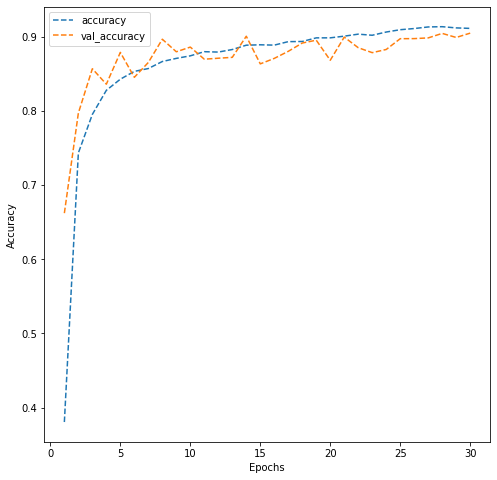

In [104]:
# plotting the accuracies

dict_hist = history_model_2.history
list_ep = [i for i in range(1,31)]

plt.figure(figsize = (8,8))
plt.plot(list_ep,dict_hist['accuracy'],ls = '--', label = 'accuracy')
plt.plot(list_ep,dict_hist['val_accuracy'],ls = '--', label = 'val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

**Observations:**
- Using the batch normalization and dropout class helped to normalize each batch while training the model i.e. centering and scaling each batch separately. It helped reduce the training process time and reduced overfitting so that the model can generalize appropriately.
- The validation accuracy has improved as compared to the previous model.
- We have been able to achieve the best validation accuracy so far without actually training any of the convolutional layers. There are other pre-trained models as well which can be tried and/or tuned to get better performance.

## **Predictions on the test data**

- Make predictions on the test set using the second model
- Print the obtained results using the classification report and the confusion matrix
- Final observations from the obtained results

#### **Question 7: Make predictions on the test data using the second model (1 Mark)**

In [105]:
#Make prediction on the test data using model_2 
test_pred= model_2.predict(X_test)

#Converting probabilities to class labels
test_pred= np.argmax(test_pred, axis=1)

**Note:** Earlier, we noticed that each entry of the test data is a one-hot encoded vector but to print the classification report and confusion matrix, we must convert each entry of y_test to a single label.

In [106]:
#Converting each entry to single label from one-hot encoded vector
y_test = np.argmax(y_test, axis=-1)

#### **Question 8: Write your final observations on the performance of the model on the test data (2 Marks)**

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1814
           1       0.95      0.85      0.89      1828
           2       0.92      0.92      0.92      1803
           3       0.89      0.87      0.88      1719
           4       0.90      0.94      0.92      1812
           5       0.89      0.90      0.90      1768
           6       0.89      0.90      0.89      1832
           7       0.91      0.93      0.92      1808
           8       0.86      0.91      0.89      1812
           9       0.92      0.90      0.91      1804

    accuracy                           0.90     18000
   macro avg       0.90      0.90      0.90     18000
weighted avg       0.90      0.90      0.90     18000



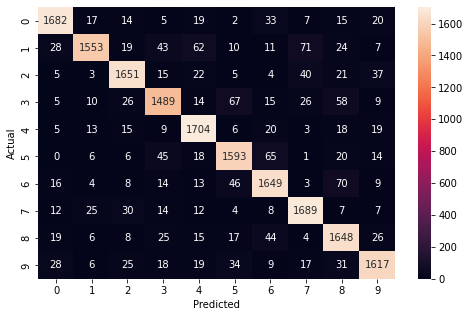

In [107]:
#importing required functions
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Printing the classification report
print(classification_report(y_test, test_pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### **Observations:**
- The model is giving about 90% accuracy on the test data which is comparable to the accuracy of the validation data. This implies that the model is giving a generalized performance.
- The recall has a low range which implies that the model is good at identifying most numbers, for example the highest percentage of predicted value that was inaccurate was 0.03% (5's that actually turned out to be 3s)-this makes sense because I mistake 5's for 3's all the time.
- Another common mistake in the model is predicted 6's that are actually 8's, this makes sense because the only thing missing to make a 6 an 8 is a small line on top. The same can be said for predicted 8's that were actualy 3's, lines in the background or some other object could have made the 3 look like an 8. 
- The model is very good at recognizing the number 4, the model predicted 95% of 4's correctly. 
- The model does a fantastic job at predicting numbers that are clearly do not resemble other numbers such as 0, however it does have some room to learn when it comes to fine-tuning features that seperate similar numbers.
